# **Dataset 4**

### **Import Packages**

In [1]:
import multiprocessing
import subprocess
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from Data_Generation.data_synthesizer import ds_generate_data
from Data_Generation.synthetic_data_vault import sdv_generate_data
from Data_Evaluation.utility import run_utility_eval
from Data_Evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from Data_Evaluation.privacy import dcr, nndr, mia


### **Exploratory Data Analysis**

In [2]:
# Load dataset as dataframe
data_path = "Original_Data/Dataset_4.csv"
original_data = pd.read_csv(data_path)
original_data.head()


,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [3]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [4]:
# Check for missing values
original_data.isnull().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

Found 173 missing values in column 'score'. Replace with mean value.

In [5]:
original_data.fillna(original_data.mean().round(0), inplace=True)
original_data.isnull().sum()

id_assessment     0
id_student        0
date_submitted    0
is_banked         0
score             0
dtype: int64

In [6]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173912 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


<Axes: xlabel='score', ylabel='Count'>

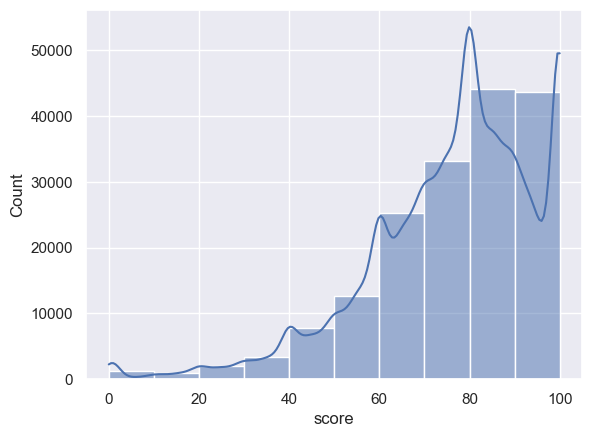

In [7]:
# Check score distribution
sns.histplot(original_data['score'], bins=10, kde=True)

In [8]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

### **Synthetic Data Generation**

In [9]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
train_data.to_csv("Original_Data/train_data.csv", index=False)
test_data.to_csv("Original_Data/test_data.csv", index=False)

In [10]:
# Use train_data.csv to fit SDG models and generate synthetic data
data_path = "Original_Data/train_data.csv"
arguments = [data_path, str(n)]

print("Sampling synthpop...")
result = subprocess.run(['Rscript', 'Data_Generation/synthpop.R',   *arguments], capture_output=True, text=True)

print("Sampling DataSynthesizer...")
ds_generate_data(data_path=data_path, num_samples=n)

sdv_generate_data(data_path=data_path, num_samples=n)

Sampling synthpop...
Sampling DataSynthesizer...
================ Constructing Bayesian Network (BN) ================
Adding ROOT is_banked
Adding attribute date_submitted
Adding attribute id_assessment
Adding attribute score
Adding attribute id_student
========================== BN constructed ==========================


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sdv/single_table/base.py:97: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Fitting copula_gan...

Time taken to fit copula_gan: 1168.92 seconds

Fitting ctgan...

Time taken to fit ctgan: 2430.63 seconds

Fitting tvae...

Time taken to fit tvae: 720.00 seconds

Fitting gaussian_copula...

Time taken to fit gaussian_copula: 7.02 seconds



Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [11]:

synthpop = pd.read_csv("Synthetic_Data/synthpop_samples.csv")
ds = pd.read_csv("Synthetic_Data/ds_samples.csv")
tvae = pd.read_csv("Synthetic_Data/tvae_samples.csv")
gaussian_copula = pd.read_csv("Synthetic_Data/gaussian_samples.csv")
copula_gan = pd.read_csv("Synthetic_Data/copula_gan_samples.csv")
ctgan = pd.read_csv("Synthetic_Data/ctgan_samples.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le


### **Utility Evaluation**

Prepare utility evaluation

In [12]:
models = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]
target_col = "score"

Run random forest classifier for utility evaluation

In [13]:
rf_results = {}
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    rf_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "random_forest")
    print(rf_results[model_names[i]])

Model:  synthpop


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

{'acc_original': 0.10307816153639744, 'f1_original': 0.10184225570437519, 'acc_synth': 0.09755817073638211, 'f1_synth': 0.09497845653261018, 'acc_diff': 0.005519990800015334, 'f1_diff': 0.006863799171765009}
Model:  ds


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

{'acc_original': 0.10307816153639744, 'f1_original': 0.10184225570437519, 'acc_synth': 0.021083298194503008, 'f1_synth': 0.02277202764757306, 'acc_diff': 0.08199486334189443, 'f1_diff': 0.07907022805680212}
Model:  tvae


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

{'acc_original': 0.10307816153639744, 'f1_original': 0.10184225570437519, 'acc_synth': 0.04852991911680147, 'f1_synth': 0.044048497513026565, 'acc_diff': 0.05454824241959597, 'f1_diff': 0.057793758191348625}
Model:  gaussian_copula


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

{'acc_original': 0.10307816153639744, 'f1_original': 0.10184225570437519, 'acc_synth': 0.013531644113926477, 'f1_synth': 0.012657689147403969, 'acc_diff': 0.08954651742247097, 'f1_diff': 0.08918456655697123}
Model:  copula_gan


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

{'acc_original': 0.10307816153639744, 'f1_original': 0.10184225570437519, 'acc_synth': 0.05134741442097596, 'f1_synth': 0.04788619771996157, 'acc_diff': 0.05173074711542148, 'f1_diff': 0.05395605798441362}
Model:  ctgan
{'acc_original': 0.10307816153639744, 'f1_original': 0.10184225570437519, 'acc_synth': 0.06991988346686089, 'f1_synth': 0.05172090204871342, 'acc_diff': 0.033158278069536556, 'f1_diff': 0.05012135365566177}


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Run logistic regression for utility evaluation

In [14]:
lr_results = {}
for i, model in enumerate(models):
    lr_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "logistic_regression")

for name in model_names:
    print(name)
    print(lr_results[name], "\n")

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedM

synthpop
{'acc_original': 0.10725648790585349, 'f1_original': 0.020779203957803572, 'acc_synth': 0.10725648790585349, 'f1_synth': 0.020779203957803572, 'acc_diff': 0.0, 'f1_diff': 0.0} 

ds
{'acc_original': 0.10725648790585349, 'f1_original': 0.020779203957803572, 'acc_synth': 0.012285812856978572, 'f1_synth': 0.0009671943997392537, 'acc_diff': 0.09497067504887491, 'f1_diff': 0.01981200955806432} 

tvae
{'acc_original': 0.10725648790585349, 'f1_original': 0.020779203957803572, 'acc_synth': 0.10744815425307624, 'f1_synth': 0.021253237011183684, 'acc_diff': -0.00019166634722275755, 'f1_diff': -0.00047403305338011154} 

gaussian_copula
{'acc_original': 0.10725648790585349, 'f1_original': 0.020779203957803572, 'acc_synth': 0.004408325986123357, 'f1_synth': 0.00012289919642169232, 'acc_diff': 0.10284816191973013, 'f1_diff': 0.02065630476138188} 

copula_gan
{'acc_original': 0.10725648790585349, 'f1_original': 0.020779203957803572, 'acc_synth': 0.10645148924751792, 'f1_synth': 0.021189864409

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedM

Run multilayer perceptron (MLP)

In [15]:
mlp_results = {}
for i, model in enumerate(models):
    mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "multilayer_perceptron")

for name in model_names:
    print(name)
    print(mlp_results[name], "\n")

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

synthpop
{'acc_original': 0.10727565454057576, 'f1_original': 0.020818182626679393, 'acc_synth': 0.1036531605780657, 'f1_synth': 0.02218401644529241, 'acc_diff': 0.003622493962510062, 'f1_diff': -0.001365833818613018} 

ds
{'acc_original': 0.10727565454057576, 'f1_original': 0.020818182626679393, 'acc_synth': 0.022271629547284087, 'f1_synth': 0.002052127386849384, 'acc_diff': 0.08500402499329168, 'f1_diff': 0.01876605523983001} 

tvae
{'acc_original': 0.10727565454057576, 'f1_original': 0.020818182626679393, 'acc_synth': 0.01820830298616169, 'f1_synth': 0.0013092164518646613, 'acc_diff': 0.08906735155441407, 'f1_diff': 0.01950896617481473} 

gaussian_copula
{'acc_original': 0.10727565454057576, 'f1_original': 0.020818182626679393, 'acc_synth': 0.005251657913903477, 'f1_synth': 0.0012189273334575158, 'acc_diff': 0.10202399662667229, 'f1_diff': 0.019599255293221877} 

copula_gan
{'acc_original': 0.10727565454057576, 'f1_original': 0.020818182626679393, 'acc_synth': 0.00866331889446851, '

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [16]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Difference in pairwise correlation: ", pairwise_correlation_diff(train_data, model))

Model:  synthpop
Difference in pairwise correlation:  0.007166874266176885
Model:  ds
Difference in pairwise correlation:  0.056455902749672104
Model:  tvae
Difference in pairwise correlation:  0.025677050854370963
Model:  gaussian_copula
Difference in pairwise correlation:  0.0272596774363421
Model:  copula_gan
Difference in pairwise correlation:  0.08720062529942808
Model:  ctgan
Difference in pairwise correlation:  0.10076483523577628


**Jensen-Shannon Divergence**

In [17]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Jensen-Shannon Divergence: ", jsd(train_data, model))

Model:  synthpop
Jensen-Shannon Divergence:  0.08090129538189528
Model:  ds
Jensen-Shannon Divergence:  0.29908389952657727
Model:  tvae
Jensen-Shannon Divergence:  0.17309437451383228
Model:  gaussian_copula
Jensen-Shannon Divergence:  0.30670634730201585
Model:  copula_gan
Jensen-Shannon Divergence:  0.25592923675538964
Model:  ctgan
Jensen-Shannon Divergence:  0.23282315569378817


**Wasserstein Distance**

In [18]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Wasserstein Distance: ", wd(train_data, model)) 

Model:  synthpop
Wasserstein Distance:  0.0006510747384013166
Model:  ds
Wasserstein Distance:  0.0032785246592786305
Model:  tvae
Wasserstein Distance:  0.0020706341555319693
Model:  gaussian_copula
Wasserstein Distance:  0.0019766432834011235
Model:  copula_gan
Wasserstein Distance:  0.07508942499858245
Model:  ctgan
Wasserstein Distance:  0.07464955408752165


### **Privacy**

**Distance to closest record (DCR)**

In [19]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Avg. DCR: ", dcr(train_data, model, model_names[i], save_hist=True))
    

Model:  synthpop
Avg. DCR:  0.1582234
Model:  ds
Avg. DCR:  0.16516887
Model:  tvae
Avg. DCR:  0.15598643
Model:  gaussian_copula
Avg. DCR:  0.16494773
Model:  copula_gan
Avg. DCR:  0.23829481
Model:  ctgan
Avg. DCR:  0.23606841


<Figure size 640x480 with 0 Axes>

**Nearest Neighbor distance ratio (NNDR)**

In [20]:
for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Avg. NNDR: ", nndr(train_data, model))

Model:  synthpop
Avg. NNDR:  0.44213414
Model:  ds
Avg. NNDR:  0.86754346
Model:  tvae
Avg. NNDR:  0.739678
Model:  gaussian_copula
Avg. NNDR:  0.8924835
Model:  copula_gan
Avg. NNDR:  0.7419581
Model:  ctgan
Avg. NNDR:  0.7745233


**Membership Inference Attack (MIA)**

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

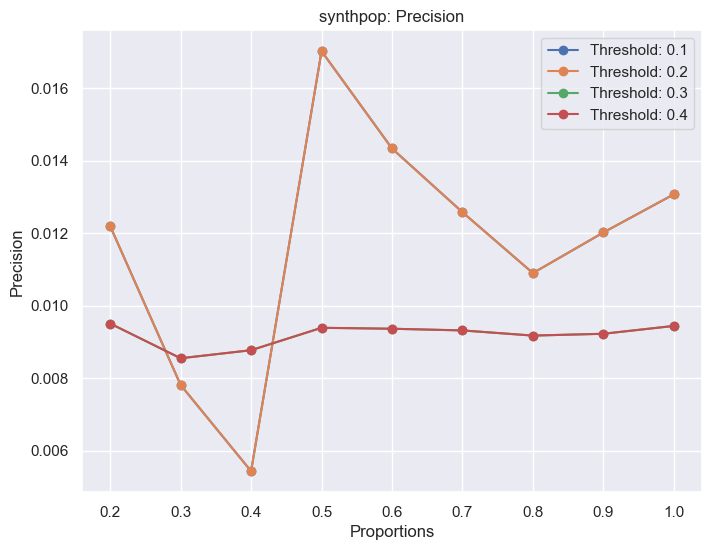

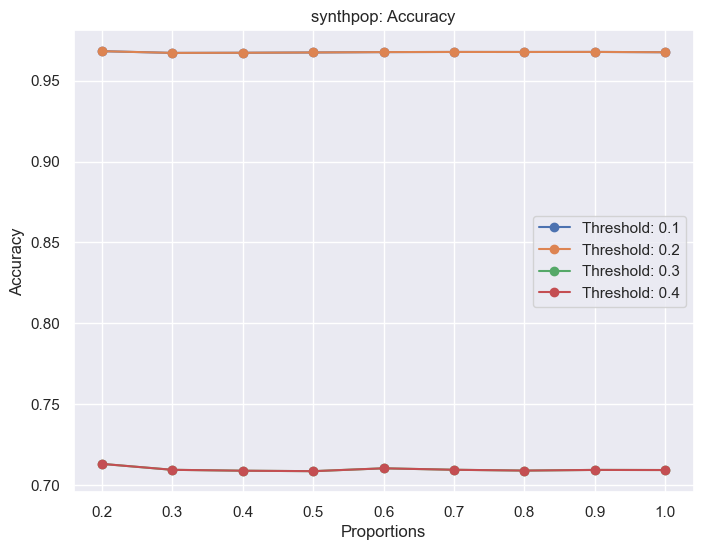

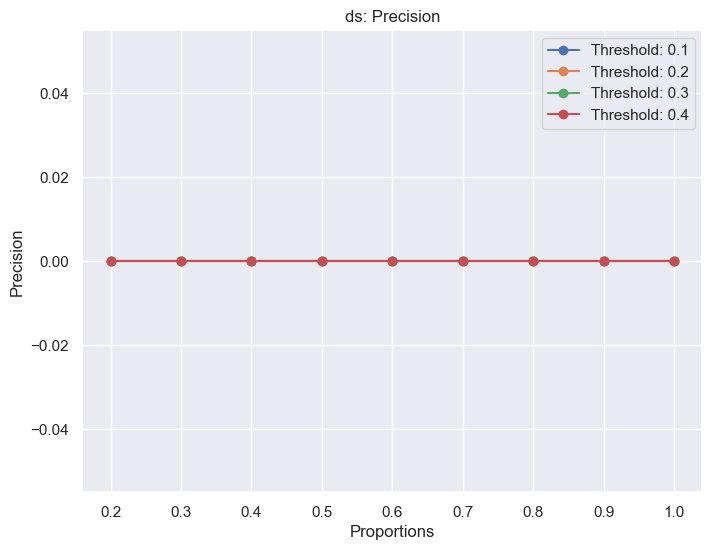

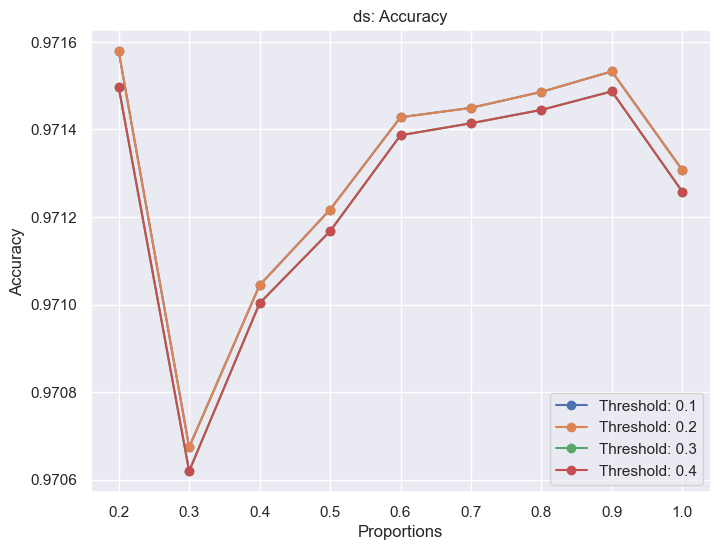

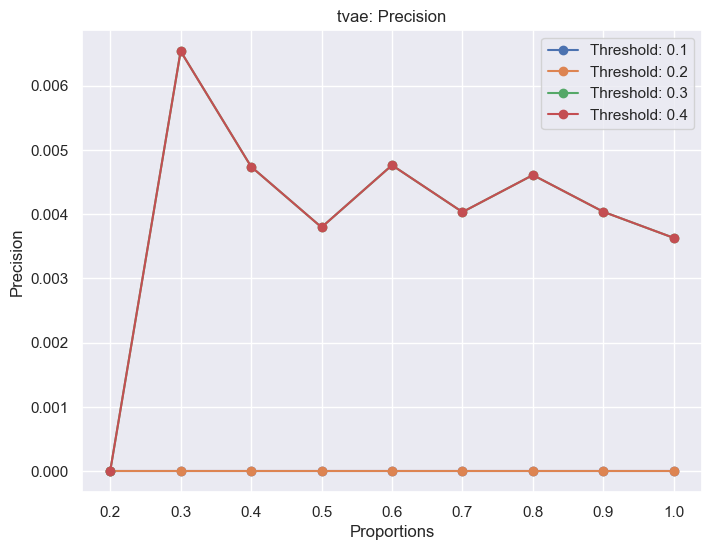

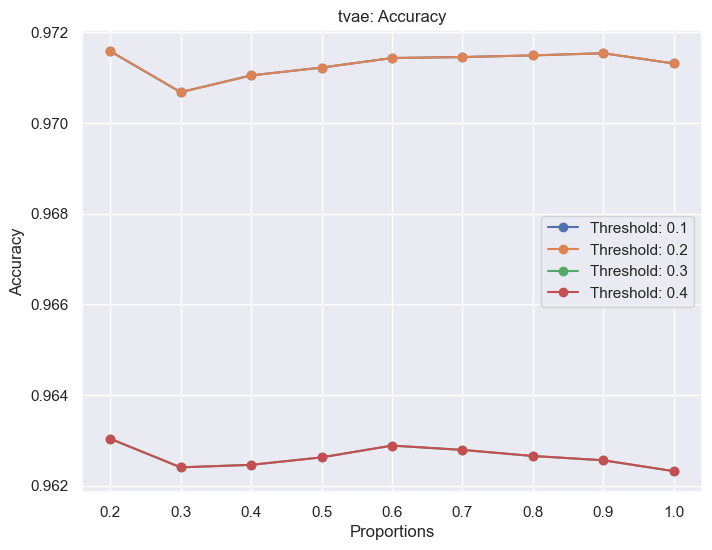

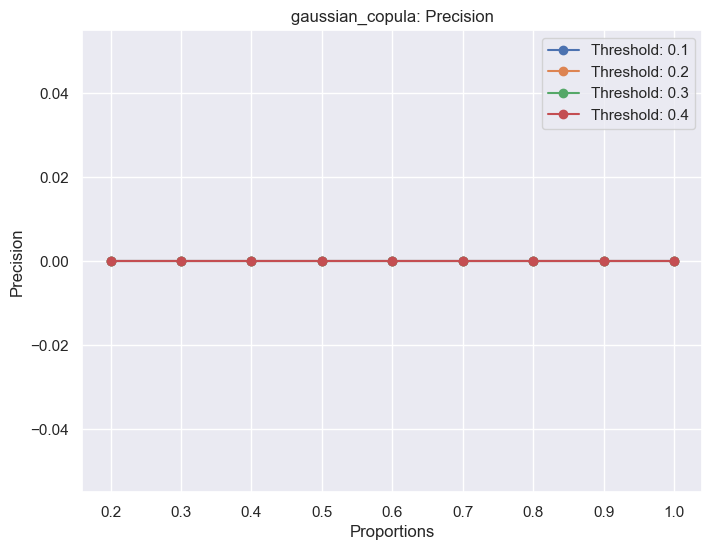

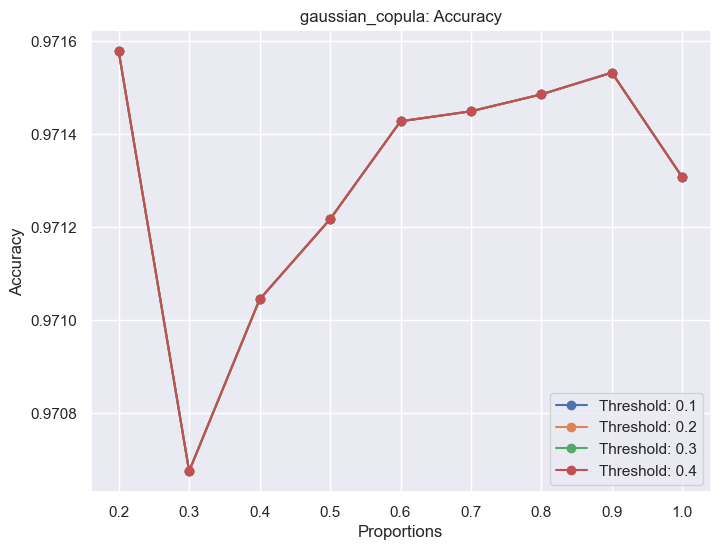

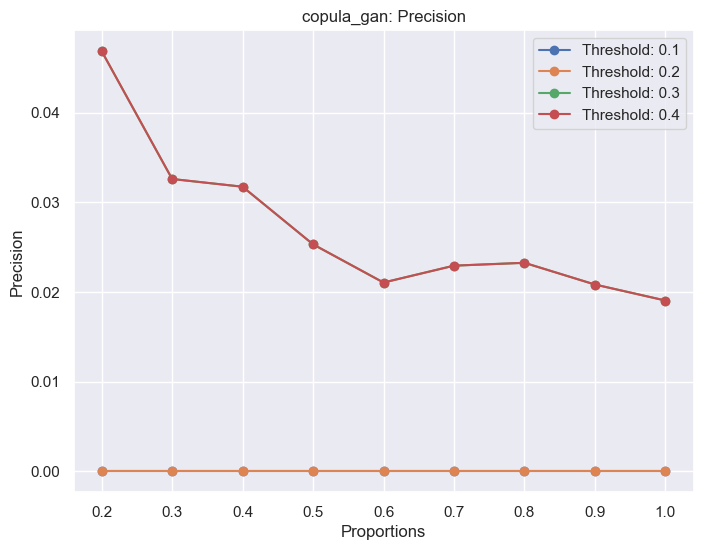

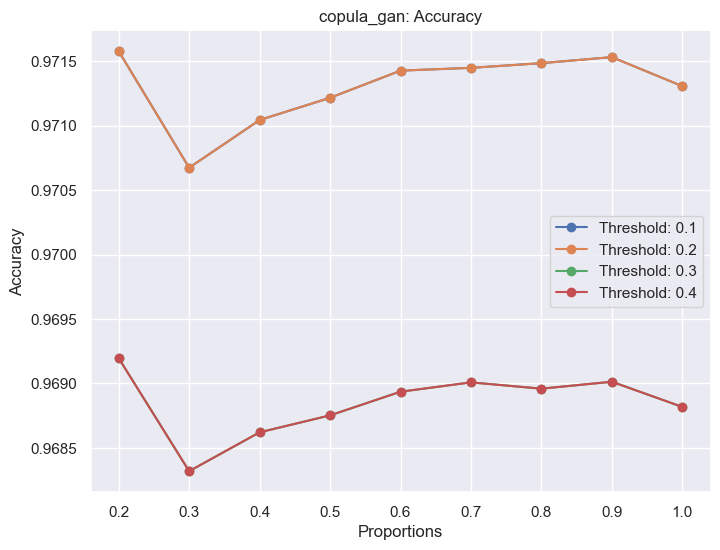

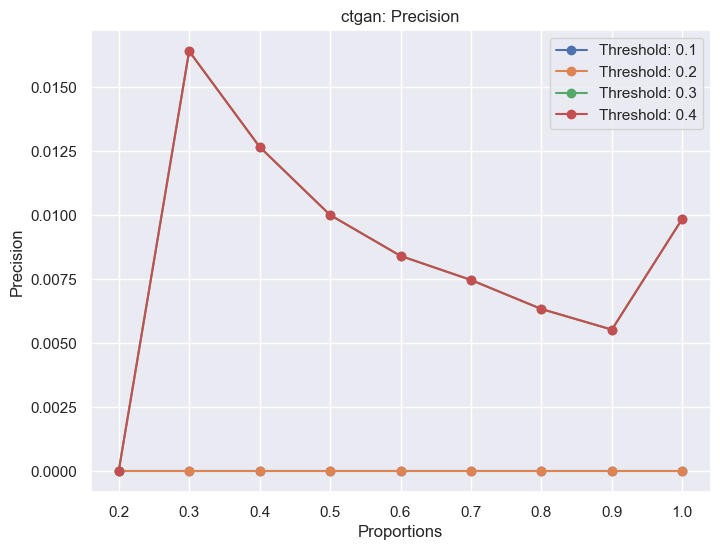

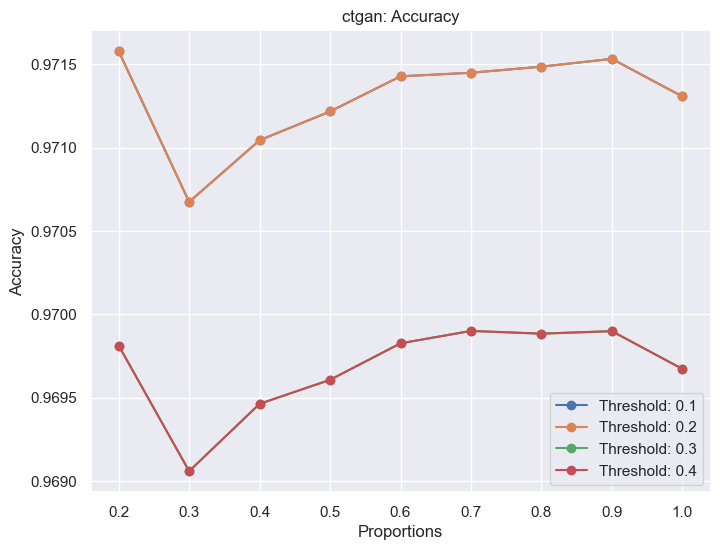

In [21]:
mia_results = {}
for i, model in enumerate(models):
    mia_results[model_names[i] + "prec"], mia_results[model_names[i] + "acc"]= mia(train_data, model, model_names[i],save_plts=True)
